In [1]:
import numpy as np
from numpy.random import choice
import random
import tensorflow as tf
from copy import copy, deepcopy

In [19]:
class Board():
    
    def __init__(self, deck):
        
        self.deck = random.sample(deck, 5) # each game only 5 cards are selected from the deck
        self.player = 1
        self.player1_cards = self.deck[:2]
        self.player2_cards = self.deck[2:4]
        self.remaining_card = self.deck[4]
        self.board_size = 5 # 5x5 board
        self.board_2D = np.array([[-1, -1, -2, -1, -1],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [ 0,  0,  0,  0,  0],
                                  [ 1,  1,  2,  1,  1]])
        self.board_state = self.get_board_state()
        self.layer_code = self.get_layer_codes()
        self.layer_decode = {k :v for v,k in self.layer_code.items()}
        
    def get_layer_codes(self):
        """return the 'codes' of each plane of the NN"""
        
        layer_code = {}
        i = 0
        for card in deck:
            for move in card.moves:
                if move not in layer_code :
                    layer_code[move] = i
                    i += 1
        return layer_code
            
    def get_board_state(self):
        """ Return the board state, a 5 x 5 x 10 
        See NNet_architecture to understand the input dimension."""
        
        board_state = np.zeros((self.board_size, self.board_size, 10))
                
        if self.player == 1:
            for k, piece in enumerate([1, 2, -1, -2]):
                for i in range(self.board_size):
                    for j in range(self.board_size):
                        if self.board_2D[i][j] == piece:
                            board_state[i, j, k] = 1
            board_state[:, :, 4] = self.player1_cards[0].map
            board_state[:, :, 5] = self.player1_cards[1].map
            board_state[:, :, 6] = self.player2_cards[0].map
            board_state[:, :, 7] = self.player2_cards[1].map
            board_state[:, :, 9] = np.ones((5, 5)) 

        else:
            for k, piece in enumerate([-1, -2, 1, 2]):
                for i in range(self.board_size):
                    for j in range(self.board_size):
                        if self.board_2D[i][j] == piece:
                            board_state[i, j, k] = 1
            board_state[:, :, 4] = self.player2_cards[0].map
            board_state[:, :, 5] = self.player2_cards[1].map
            board_state[:, :, 6] = self.player1_cards[0].map
            board_state[:, :, 7] = self.player1_cards[1].map
            board_state[:, :, 9] = -np.ones((5, 5)) 
        board_state[:, :, 8] = self.remaining_card.map
        
        return board_state
        
        
    def get_legal_moves(self, policy):
        """Returns all the legal moves for a policy obtained with the neural network """
        
        # transform to positive output
        policy = policy - np.min(policy) + 1e-9 #to avoid div by 0 if all element are equals and negatifs
        
        possible_policy = np.zeros((5, 5, 13))
        
        
        player_board2D = self.board_state[:, :, 0] + self.board_state[:, :, 1]
        
        if self.player == 1:
            player_cards = self.player1_cards
        else:
            player_cards = self.player2_cards
       
        # keep only the possible moves, considering the 2 card the player have.
        possibles_moves = set()
        for card in player_cards:
            for move in card.moves:
                possibles_moves.add(move)
            
        for line, column in possibles_moves:
            for i in range(5):
                for j in range(5):
                    if player_board2D[i][j] != 0 :
                        if (0 <= i + line < 5) and (0 <= j + column < 5):
                            possible_policy[i + line, j +  column , self.layer_code[line, column]] = policy[i + line, j + column, self.layer_code[line, column]]
                            
        # The illegal moves are the one where there is already an ally piece on the board
        # we can perform element wise multiplication for each plane to get the legal moves
        for k in range(possible_policy.shape[2]):
            possible_policy[:, :, k] = tf.multiply(possible_policy[:, :, k], (1 - player_board2D))
            
        # Then we normalize to [0, 1]
        possible_policy = possible_policy / np.sum(possible_policy)
        return possible_policy


    
    def move(self, action):
    
        # create the next state
        cls = self.__class__
        next_state = cls.__new__(cls)
        next_state.board_size = self.board_size
        next_state.layer_code = self.layer_code
        next_state.layer_decode = self.layer_decode
        next_state.player = self.player * (-1)
        
        # find the piece to move in the board
        plane = action % 13
        column = action // 13 % 5
        line = action // 13 // 5
        piece_to_move = (line - self.layer_decode[plane][0], column - self.layer_decode[plane][1])
        
        # move the piece
        next_state.board_2D = self.board_2D.copy()
        next_state.board_2D[line, column] = self.board_2D[piece_to_move]
        next_state.board_2D[piece_to_move] = 0 
        
        # turn the board
        next_state.board_2D = np.rot90(np.rot90(next_state.board_2D)) # turn the board to the new curr play
        
        
        # How to know which card the policy choose to move when both can play the move ??
        # -> Add other head to the NN the predict the card to play ? 

        if self.player == 1:
            if (line, column) in self.player1_cards[0].moves:
                print(f"player {self.player} plays {self.player1_cards[0].name}")
                next_state.player1_cards = [self.player1_cards[1], self.remaining_card]
                next_state.remaining_card = self.player1_cards[0]
            else:
                print(f"player {self.player} plays {self.player1_cards[1].name}")
                next_state.player1_cards = [self.player1_cards[0], self.remaining_card]
                next_state.remaining_card = self.player1_cards[1]
            
            next_state.player2_cards = self.player2_cards
            next_state.board_state = next_state.get_board_state()
            
        else:
            if (line, column) in self.player2_cards[0].moves:
                print(f"player {self.player} plays {self.player2_cards[0].name}")
                next_state.player2_cards = [self.player2_cards[1], self.remaining_card]
                next_state.remaining_card = self.player2_cards[0]
            else:
                print(f"player {self.player} plays {self.player2_cards[1].name}")
                next_state.player2_cards = [self.player2_cards[0], self.remaining_card]
                next_state.remaining_card = self.player2_cards[1]
                
            next_state.player1_cards = self.player1_cards
            next_state.board_state = next_state.get_board_state()
            
        return next_state
    
    def is_game_over(self):
        """check if the game is over"""
        
        # if a king managed to reach it's opposite case
        if self.player == 1:
            if self.board_2D[4][2] == -2:
                return True
            if self.board_2D[0][2] == 2:
                return True
        else:
            if self.board_2D[4][2] == 2:
                return True
            if self.board_2D[0][2] == -2:
                return True

        king1_alive = True
        king2_alive = True
        for i in range(self.board_size):
            for j in range(self.board_size):
                if self.board_2D[i][j] == 2:
                    king1_alive = False
                if self.board_2D[i][j] == -2:
                    king2_alive = False
                    
        return king1_alive or king2_alive

In [20]:
# random policy only used for example
policy = np.array([[[[ 4.4887428e+00,  3.9325886e+00,  5.3513274e+00,
           2.4256887e+00, -4.1401563e+00,  2.8321390e+00,
           2.5634553e+00,  1.7598315e+00,  1.7805212e+00,
          -5.8160591e+00,  3.7879453e+00, -3.4550591e+00,
           3.5489273e+00],
         [ 6.0892835e+00,  4.8931589e+00,  8.0664330e+00,
           4.2840252e+00, -3.5654471e+00,  4.1610394e+00,
           3.9368446e+00,  1.5831723e+00,  4.0845032e+00,
          -5.3345280e+00,  3.5315082e+00, -6.6064529e+00,
           3.8729019e+00],
         [ 6.8604751e+00,  1.7142516e+00,  7.6234002e+00,
           4.5962591e+00, -3.1513143e+00,  5.7896967e+00,
           2.8120902e+00,  3.8376814e-01,  5.6353307e+00,
          -4.8424859e+00,  3.0849779e+00, -7.0349288e+00,
           6.2922359e+00],
         [ 6.2820597e+00,  1.8113070e+00,  7.6099701e+00,
           5.1939983e+00, -2.4807429e+00,  4.8054485e+00,
           3.0330696e+00, -9.7384250e-01,  5.5571179e+00,
          -4.8500509e+00,  2.0741193e+00, -5.2086082e+00,
           4.5507855e+00],
         [ 6.3450518e+00,  2.7256098e+00,  3.8435783e+00,
           4.2613883e+00, -2.0502307e+00,  4.1768627e+00,
          -2.9620016e-01, -1.9139215e+00,  1.5461363e+00,
          -3.6188490e+00,  6.6855407e-01, -2.4713898e+00,
           2.5187194e+00]],

        [[ 5.3521285e+00,  3.7175691e+00,  4.0217171e+00,
           2.1388843e+00, -5.8118978e+00,  3.3877378e+00,
           5.8352361e+00,  4.3121028e-01,  3.3593011e+00,
          -7.5680890e+00,  5.3677492e+00, -4.1762705e+00,
           6.5307183e+00],
         [ 8.6227398e+00,  3.2874112e+00,  8.3496361e+00,
           3.1607080e+00, -8.0907269e+00,  5.8723845e+00,
           3.4900715e+00,  2.9017143e+00,  5.0599251e+00,
          -7.0836039e+00,  6.4845333e+00, -7.5172334e+00,
           6.4166846e+00],
         [ 9.9286966e+00,  3.5973833e+00,  6.9175601e+00,
           2.8860469e+00, -7.3611622e+00,  5.8203940e+00,
           4.1931677e+00,  1.2709285e+00,  5.7894139e+00,
          -6.8684025e+00,  6.4035163e+00, -7.3659930e+00,
           7.5574884e+00],
         [ 1.2005533e+01,  2.9386787e+00,  7.2302465e+00,
           5.5401607e+00, -6.0278955e+00,  5.0690312e+00,
           1.8107853e+00,  2.5792986e-01,  6.0318432e+00,
          -5.2287002e+00,  4.9230227e+00, -7.9373364e+00,
           5.8458118e+00],
         [ 9.2329311e+00,  4.6583500e+00,  2.6445177e+00,
           4.0735407e+00, -4.1342602e+00,  2.7057369e+00,
           2.8123260e-01, -2.1186732e-01,  1.0835546e+00,
          -4.4431262e+00, -1.1709918e-01, -3.5127537e+00,
           3.0502427e+00]],

        [[ 6.3683577e+00,  4.2345548e+00,  6.4786882e+00,
           2.4514153e+00, -6.5665550e+00,  4.2784219e+00,
           6.3443837e+00, -6.9532937e-01,  4.2030697e+00,
          -6.9903169e+00,  4.1162362e+00, -5.2620549e+00,
           5.2252660e+00],
         [ 1.0892622e+01,  3.5166526e+00,  9.7275229e+00,
           3.4333284e+00, -7.2915754e+00,  4.5320497e+00,
           3.8838322e+00,  5.4241639e-01,  5.4191999e+00,
          -5.9633784e+00,  4.4165869e+00, -6.6117206e+00,
           2.6986241e+00],
         [ 1.3184305e+01,  4.8868818e+00,  1.0886459e+01,
           4.4725461e+00, -7.5145755e+00,  5.3825331e+00,
           1.0040456e+00,  1.1042621e+00,  6.0423880e+00,
          -5.8965273e+00,  4.7357178e+00, -7.0155697e+00,
           3.0666893e+00],
         [ 1.2790770e+01,  4.3610358e+00,  1.0993142e+01,
           4.1117711e+00, -5.8926797e+00,  6.8330746e+00,
           3.2980141e-01, -1.2602828e+00,  4.4286137e+00,
          -7.1247034e+00,  5.3334990e+00, -7.3357153e+00,
           1.4403038e+00],
         [ 1.1833016e+01,  4.6556644e+00,  4.9799113e+00,
           2.9123240e+00, -2.5901070e+00,  2.7203181e+00,
          -3.5394338e-01, -1.0204467e+00,  6.7418003e-01,
          -5.0782475e+00,  2.3299379e+00, -5.1286173e+00,
           1.4782281e+00]],

        [[ 5.3655796e+00,  6.9796147e+00,  7.6489635e+00,
           1.7883654e+00, -7.1815524e+00,  4.4072356e+00,
           7.7387018e+00, -1.6946050e+00,  5.2801137e+00,
          -6.4075370e+00,  1.5538580e+00, -3.2468402e+00,
           2.6880636e+00],
         [ 1.0363135e+01,  6.9821200e+00,  1.0529861e+01,
           4.2116618e+00, -6.8519387e+00,  5.3733301e+00,
           4.1379404e+00,  8.6826324e-02,  6.6732836e+00,
          -3.8918126e+00,  1.9440731e+00, -3.8786922e+00,
           1.6493503e+00],
         [ 1.3472421e+01,  6.9295945e+00,  1.2323790e+01,
           3.8001921e+00, -7.8609061e+00,  5.4678979e+00,
           2.9646373e+00, -2.3705813e-03,  4.8063493e+00,
          -4.7071228e+00,  5.8060098e-01, -5.1127725e+00,
           7.3094839e-01],
         [ 1.2870171e+01,  7.2914886e+00,  1.1192917e+01,
           2.2732346e+00, -4.6869731e+00,  5.3971777e+00,
           1.0489134e+00, -1.3296229e+00,  4.1990423e+00,
          -4.5424781e+00,  2.4776123e+00, -6.7653842e+00,
          -1.8550886e-01],
         [ 1.1746711e+01,  6.7474699e+00,  5.2607760e+00,
           3.3968952e+00, -2.7615979e+00,  5.5311120e-01,
          -1.8252645e-01, -4.0778512e-01,  2.0682199e+00,
          -2.7081146e+00,  4.2700571e-01, -5.5900536e+00,
           5.2274549e-01]],

        [[ 4.7182174e+00,  4.8182235e+00,  4.1810589e+00,
           2.2120075e+00, -5.6459804e+00,  1.4758966e+00,
           4.4586487e+00, -1.6292082e+00,  3.6712008e+00,
          -1.0770867e+00,  1.1104906e+00, -1.6670818e+00,
           1.5672631e+00],
         [ 8.7283964e+00,  4.8134904e+00,  6.7203684e+00,
           4.7254205e+00, -6.0203781e+00,  1.2364426e+00,
           1.4830312e+00, -1.9716709e+00,  4.2329741e+00,
          -1.6044788e+00, -5.2875012e-01, -2.3581424e+00,
          -2.6152894e-02],
         [ 9.8880310e+00,  4.6401978e+00,  8.5077953e+00,
           5.4881573e+00, -6.7473373e+00,  2.5617368e+00,
           7.2650272e-01, -1.4817581e+00,  3.8423202e+00,
          -7.1565866e-01,  1.6376919e-01, -1.3922791e+00,
          -1.7939775e+00],
         [ 1.1873071e+01,  5.4018788e+00,  6.5470848e+00,
           4.1683717e+00, -5.4685779e+00,  3.4027994e+00,
           9.5152879e-01, -1.6966366e+00,  1.1309086e+00,
          -2.8514478e+00,  2.3819470e-01, -9.9329644e-01,
          -1.7112933e+00],
         [ 1.0658359e+01,  4.1294842e+00,  3.8463349e+00,
           2.4898100e+00, -2.8022976e+00,  5.8865565e-01,
           8.5060811e-01, -1.2723875e+00,  9.1448933e-01,
          -1.8356596e+00,  8.1739628e-01, -1.2904620e+00,
          -3.8032326e-01]]]], dtype="float32")

In [21]:
%run deck.ipynb

In [22]:
root = Board(deck)

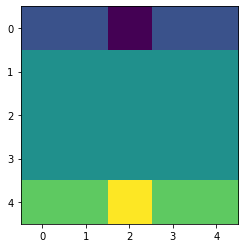

player 1 plays ox
False


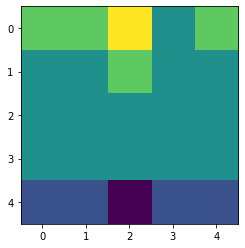

player -1 plays tiger
False


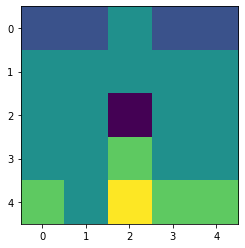

player 1 plays goose
False


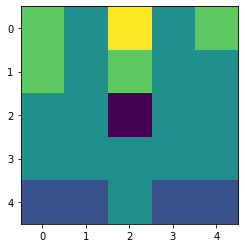

player -1 plays ox
False


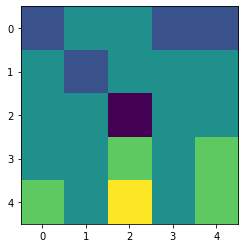

player 1 plays tiger
False


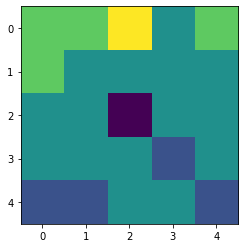

player -1 plays goose
False


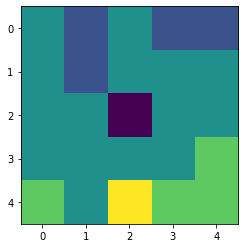

player 1 plays ox
False


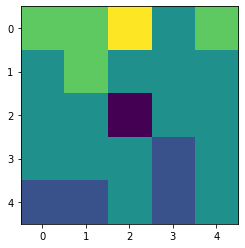

player -1 plays tiger
False


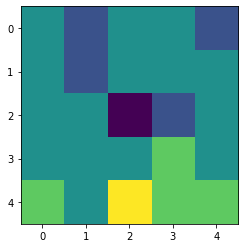

player 1 plays goose
False


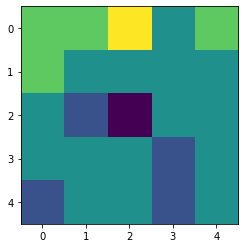

player -1 plays ox
False


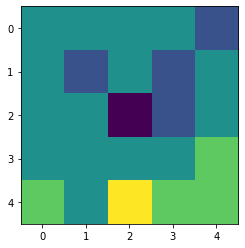

player 1 plays tiger
True


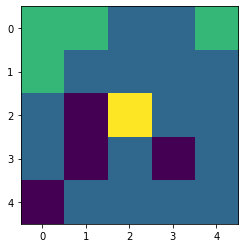

player -1 plays goose
True


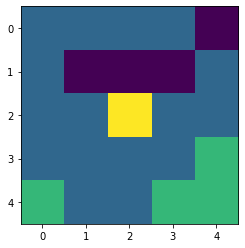

player 1 plays ox
True


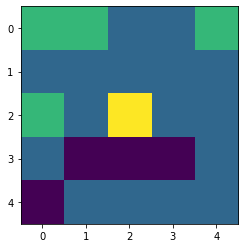

player -1 plays tiger
True


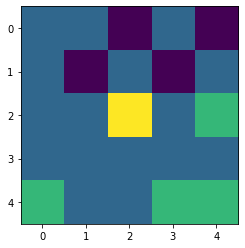

player 1 plays goose
True


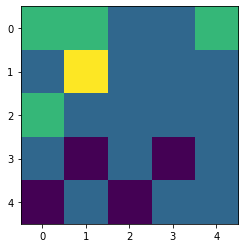

player -1 plays ox
True


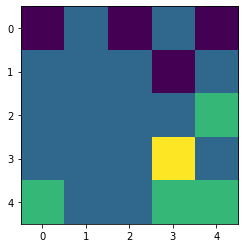

player 1 plays tiger
True


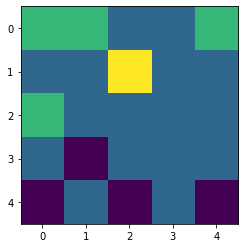

player -1 plays goose
True


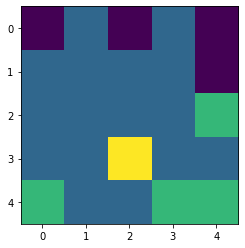

player 1 plays ox
True


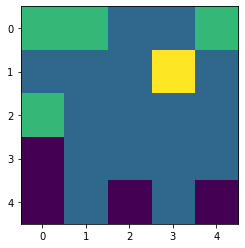

player -1 plays tiger
True


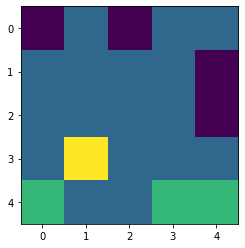

In [23]:
plt.imshow(root.board_2D)
plt.show()
for i in range(20):
    possible_policy = root.get_legal_moves(policy[0])
    action = choice(len(possible_policy.flatten()), 1,
                  p=possible_policy.flatten())[0]
    root = root.move(action)
    plt.imshow(root.board_2D)
    plt.show()